In [1]:
import numpy
import csv

import matplotlib.pyplot as plt

import project_module as pm

inputFile = './input/trainData.txt'

# restart kernel
import importlib
importlib.reload(pm)

D, L = pm.load(inputFile)
(DTR, LTR), (DVAL, LVAL) = pm.split_db_2to1(D, L)

# Confusion marices with 5 different applications (JUST FOR MY VISUALIZATION)

In [2]:
def computeConfusionMatrixMVG(DTR, LTR, DVAL, LVAL, ML_func=pm.Gau_MVG_ML_estimates, prior1=1/2, Cfn=1.0, Cfp=1.0):
  hParams = ML_func(DTR, LTR)

  S_logLikelihood = pm.compute_log_likelihood_Gau(DVAL, hParams)

  llr = S_logLikelihood[1] - S_logLikelihood[0]
  threshold = -numpy.log( (prior1 * Cfn) / ((1 - prior1) * Cfp) )       # new threshold

  predictions_class1 = numpy.array(llr >= threshold)

  tp = numpy.sum((predictions_class1 == 1) & (LVAL == 1))  # True Positives
  tn = numpy.sum((predictions_class1 == 0) & (LVAL == 0))  # True Negatives
  fp = numpy.sum((predictions_class1 == 1) & (LVAL == 0))  # False Positives
  fn = numpy.sum((predictions_class1 == 0) & (LVAL == 1))  # False Negatives

  # Confusion matrix as 2x2 array
  confusion_matrix = numpy.array([[tp, fn], [fp, tn]])

  return confusion_matrix


we can see that (0.9, 1, 1) is equal to (0.5, 9, 1) and (0.1, 1, 1) is equal to (0.5, 1, 9)

In [13]:
applications = [
  (0.5, 1.0, 1.0),
  (0.9, 1.0, 1.0),
  (0.1, 1.0, 1.0),
  (0.5, 1.0, 9.0),
  (0.5, 9.0, 1.0)
]

In [ ]:
for i, t in enumerate(applications):
  print(f"MVG on Application {i+1}")
  
  prior_T = t[0]
  Cfn = t[1]
  Cfp = t[2]

  print(f"π_T = {prior_T}, π_F = {1-prior_T:.1f}")
  print(f"Cfn = {Cfn}, Cfp = {Cfp}")

  
  effective_prior = (prior_T * Cfn) / ( (prior_T * Cfn) + ((1 - prior_T) * Cfp) )
  if effective_prior != prior_T:
    print(f"Effective prior: {effective_prior}")
    print(f"Equivalent application: (π_T={effective_prior}, Cfn=1, Cfp=1)")

  print()
  confusion_matrix = computeConfusionMatrixMVG(DTR, LTR, DVAL, LVAL, prior1=prior_T, Cfn=Cfn, Cfp=Cfp)
  print("Confusion Matrix:")
  print(confusion_matrix)

  print("\n")


# DCF

In [3]:
# Optimal Bayes deicsions for binary tasks with log-likelihood-ratio scores
def compute_optimal_Bayes_binary_llr(llr, prior, Cfn, Cfp):
  th = -numpy.log( (prior * Cfn) / ((1 - prior) * Cfp) )
  return numpy.int32(llr > th)

# Assume that classes are labeled 0, 1, 2 ... (nClasses - 1)
def compute_confusion_matrix(predictedLabels, classLabels):
  nClasses = classLabels.max() + 1
  M = numpy.zeros((nClasses, nClasses), dtype=numpy.int32)
  for i in range(classLabels.size):
    M[predictedLabels[i], classLabels[i]] += 1
  return M

# Specialized function for binary problems (empirical_Bayes_risk is also called DCF or actDCF)
def compute_empirical_Bayes_risk_binary(predictedLabels, classLabels, prior, Cfn, Cfp, normalize=True):
  M = compute_confusion_matrix(predictedLabels, classLabels) # Confusion matrix
  Pfn = M[0,1] / (M[0,1] + M[1,1])
  Pfp = M[1,0] / (M[0,0] + M[1,0])
  bayesError = prior * Cfn * Pfn + (1-prior) * Cfp * Pfp
  if normalize:
    return bayesError / numpy.minimum(prior * Cfn, (1-prior)*Cfp)
  return bayesError


# Compute minDCF (fast version)
# If we sort the scores, then, as we sweep the scores, we can have that at most one prediction changes everytime. We can then keep a running confusion matrix (or simply the number of false positives and false negatives) that is updated everytime we move the threshold

# Auxiliary function, returns all combinations of Pfp, Pfn corresponding to all possible thresholds
# We do not consider -inf as threshld, since we use as assignment llr > th, so the left-most score corresponds to all samples assigned to class 1 already
def compute_Pfn_Pfp_allThresholds_fast(llr, classLabels):
  llrSorter = numpy.argsort(llr)
  llrSorted = llr[llrSorter] # We sort the llrs
  classLabelsSorted = classLabels[llrSorter] # we sort the labels so that they are aligned to the llrs

  Pfp = []
  Pfn = []
  
  nTrue = (classLabelsSorted==1).sum()
  nFalse = (classLabelsSorted==0).sum()
  nFalseNegative = 0 # With the left-most theshold all samples are assigned to class 1
  nFalsePositive = nFalse
  
  Pfn.append(nFalseNegative / nTrue)
  Pfp.append(nFalsePositive / nFalse)
  
  for idx in range(len(llrSorted)):
    if classLabelsSorted[idx] == 1:
      nFalseNegative += 1 # Increasing the threshold we change the assignment for this llr from 1 to 0, so we increase the error rate
    if classLabelsSorted[idx] == 0:
      nFalsePositive -= 1 # Increasing the threshold we change the assignment for this llr from 1 to 0, so we decrease the error rate
    Pfn.append(nFalseNegative / nTrue)
    Pfp.append(nFalsePositive / nFalse)

  #The last values of Pfn and Pfp should be 1.0 and 0.0, respectively
  #Pfn.append(1.0) # Corresponds to the numpy.inf threshold, all samples are assigned to class 0
  #Pfp.append(0.0) # Corresponds to the numpy.inf threshold, all samples are assigned to class 0
  llrSorted = numpy.concatenate([-numpy.array([numpy.inf]), llrSorted])

  # In case of repeated scores, we need to "compact" the Pfn and Pfp arrays (i.e., we need to keep only the value that corresponds to an actual change of the threshold
  PfnOut = []
  PfpOut = []
  thresholdsOut = []
  for idx in range(len(llrSorted)):
    if idx == len(llrSorted) - 1 or llrSorted[idx+1] != llrSorted[idx]: # We are indeed changing the threshold, or we have reached the end of the array of sorted scores
      PfnOut.append(Pfn[idx])
      PfpOut.append(Pfp[idx])
      thresholdsOut.append(llrSorted[idx])
          
  return numpy.array(PfnOut), numpy.array(PfpOut), numpy.array(thresholdsOut) # we return also the corresponding thresholds
    
def compute_minDCF_binary_fast(llr, classLabels, prior, Cfn, Cfp, returnThreshold=False):

  Pfn, Pfp, th = compute_Pfn_Pfp_allThresholds_fast(llr, classLabels)
  minDCF = (prior * Cfn * Pfn + (1 - prior) * Cfp * Pfp) / numpy.minimum(prior * Cfn, (1-prior)*Cfp) # We exploit broadcasting to compute all DCFs for all thresholds
  idx = numpy.argmin(minDCF)
  if returnThreshold:
    return minDCF[idx], th[idx]
  else:
    return minDCF[idx]

In [4]:
effective_applications = [
  (0.5, 1.0, 1.0),
  (0.9, 1.0, 1.0),
  (0.1, 1.0, 1.0)
]

In [5]:
def binaryMVG_models_llr(DTR, LTR, DVAL, ML_func=pm.Gau_MVG_ML_estimates):
  hParams = ML_func(DTR, LTR)

  S_logLikelihood = pm.compute_log_likelihood_Gau(DVAL, hParams)
  llr = S_logLikelihood[1] - S_logLikelihood[0]

  return llr

def compute_model_DCFs(llr, prior, Cfn, Cfp, classLabels):
  predictions = compute_optimal_Bayes_binary_llr(llr, prior, 1, 1)
  DCFu = compute_empirical_Bayes_risk_binary(predictions, classLabels, prior, Cfn, Cfp, normalize=False)
  actDCF = compute_empirical_Bayes_risk_binary(predictions, classLabels, prior, Cfn, Cfp, normalize=True)
  minDCF = compute_minDCF_binary_fast(llr, classLabels, prior, Cfn, Cfp, returnThreshold=False)
  return DCFu, actDCF, minDCF

def train_model_DCF(DTR, LTR, DVAL, prior, Cfn=1, Cfp=1, ML_func=pm.Gau_MVG_ML_estimates):
  llr = binaryMVG_models_llr(DTR, LTR, DVAL, ML_func)
  return compute_model_DCFs(llr, prior, Cfn, Cfp, LVAL)

In [6]:
DCFs = {}
models = {'MVG': pm.Gau_MVG_ML_estimates, 'Tied MVG': pm.Gau_Tied_ML_estimates , 'Naive Bayes MVG':pm.Gau_Naive_ML_estimates}


for i, t in enumerate(effective_applications):
  print(f"Application {i+1}")
  
  prior = t[0]
  Cfn = t[1]
  Cfp = t[2]

  print(f"π_T = {prior}, π_F = {1-prior:.1f}")
  print(f"Cfn = {Cfn}, Cfp = {Cfp}")
  print()

  DCFs[t] = []
  for m in range(6+1):
    if m!=0:
      print(f'PCA pre-processing - {m} directions\n')
      UPCA = pm.compute_pca(DTR, m)     # trained model
      DTR_pca = pm.apply_pca(UPCA, DTR)
      DVAL_pca = pm.apply_pca(UPCA, DVAL)
      DTR_selected = DTR_pca
      DVAL_selected = DVAL_pca

    else:
      print(f'No PCA pre-processing')
      DTR_selected = DTR
      DVAL_selected = DVAL

    row = [m]
    row = {'PCA Directions': m}

    for model, func in models.items():
      DCFu, actDCF, minDCF = train_model_DCF(DTR_selected, LTR, DVAL_selected, prior, ML_func = func)
      print(f"{model:<20}Non-normalized DCF: {DCFu:.3f} - Normalized DCF: {actDCF:.3f} - minDCF: {minDCF:.3f}.")
      row[model] = ( round(actDCF, 3), round(minDCF, 3) )
    print()

    DCFs[t].append(row)

Application 1
π_T = 0.5, π_F = 0.5
Cfn = 1.0, Cfp = 1.0

No PCA pre-processing
MVG                 Non-normalized DCF: 0.070 - Normalized DCF: 0.140 - minDCF: 0.130.
Tied MVG            Non-normalized DCF: 0.093 - Normalized DCF: 0.186 - minDCF: 0.181.
Naive Bayes MVG     Non-normalized DCF: 0.072 - Normalized DCF: 0.144 - minDCF: 0.131.

PCA pre-processing - 1 directions

MVG                 Non-normalized DCF: 0.093 - Normalized DCF: 0.185 - minDCF: 0.177.
Tied MVG            Non-normalized DCF: 0.094 - Normalized DCF: 0.187 - minDCF: 0.177.
Naive Bayes MVG     Non-normalized DCF: 0.093 - Normalized DCF: 0.185 - minDCF: 0.177.

PCA pre-processing - 2 directions

MVG                 Non-normalized DCF: 0.088 - Normalized DCF: 0.176 - minDCF: 0.173.
Tied MVG            Non-normalized DCF: 0.093 - Normalized DCF: 0.185 - minDCF: 0.179.
Naive Bayes MVG     Non-normalized DCF: 0.088 - Normalized DCF: 0.177 - minDCF: 0.171.

PCA pre-processing - 3 directions

MVG                 Non-normal

Save all the DCF into a csv file

In [7]:
output_file = './outputs/L7/DCF.csv'
header1 = ["PCA", "MVG", "MVG", "Tied MVG", "Tied MVG", "Naive Bayes MVG", "Naive Bayes MVG"]
header2 = ["", "actDCF", "minDCF", "actDCF", "minDCF", "actDCF", "minDCF"]

with open(output_file, mode="w", newline="") as file:
  writer = csv.writer(file)

  for app, rows in DCFs.items():
    writer.writerow([f"{app}"])
    writer.writerow(header1)
    writer.writerow(header2)
    for row in rows:
      
      formatted_row = [row['PCA Directions']]
      t = row['MVG']
      formatted_row.append(t[0])
      formatted_row.append(t[1])
      t = row['Tied MVG']
      formatted_row.append(t[0])
      formatted_row.append(t[1])
      t = row['Naive Bayes MVG']
      formatted_row.append(t[0])
      formatted_row.append(t[1])

      writer.writerow(formatted_row)
  writer.writerow([])

print(f"File '{output_file}' saved!")

File './outputs/L7/DCF.csv' saved!


Best model with the lower minDCF

In [8]:
all_models = [
    {
        'Model': key,
        'Prior': app[0],
        'PCA Directions': obj['PCA Directions'] if obj['PCA Directions'] != 0 else None,
        'minDCF': value[1]
    }
    for app, rows in DCFs.items()
    for obj in rows
    for key, value in obj.items()
    if key != 'PCA Directions'
]

sorted_models = sorted(all_models, key=lambda x: x['minDCF'])
top_models = sorted_models[:20]

print("=== Best models ===\n")
print(f"{'#':<5} {'Model':<20} {'Prior':<10} {'PCA Directions':<15} {'minDCF':<10}")
print("=" * 70)

# Stampa dei modelli
for i, model in enumerate(sorted_models):
    print(f"{i+1:<5} {model['Model']:<20} {model['Prior']:<10} {str(model['PCA Directions']):<15} {model['minDCF']:<10.3f}")

=== Best models ===

#     Model                Prior      PCA Directions  minDCF    
1     MVG                  0.5        None            0.130     
2     MVG                  0.5        6               0.130     
3     Naive Bayes MVG      0.5        None            0.131     
4     MVG                  0.5        5               0.133     
5     MVG                  0.5        4               0.154     
6     Naive Bayes MVG      0.5        2               0.171     
7     Naive Bayes MVG      0.5        4               0.172     
8     MVG                  0.5        2               0.173     
9     MVG                  0.5        3               0.173     
10    Naive Bayes MVG      0.5        6               0.173     
11    Naive Bayes MVG      0.5        5               0.174     
12    Naive Bayes MVG      0.5        3               0.175     
13    MVG                  0.5        1               0.177     
14    Tied MVG             0.5        1               0.177     
15  

Calibration Loss (define if a model is well calibrated)

In [9]:
well_calibrated_models = []
BOUND_PERCENTAGE = 5

for app, rows in DCFs.items():
  for obj in rows:
    for key, value in obj.items():
      if key != 'PCA Directions':
        actDCF = value[0]
        minDCF = value[1]
        calibration_loss = round((actDCF - minDCF) / minDCF * 100, 2)

        #if calibration_loss < BOUND_PERCENTAGE:
        well_calibrated_models.append({
          'Model': key,
          'Prior': app[0],
          'PCA Directions': obj['PCA Directions'] if obj['PCA Directions'] != 0 else None,
          'actDCF': actDCF,
          'minDCF': minDCF,
          'Calibration Loss': calibration_loss
        })

best_models = sorted(well_calibrated_models, key=lambda x: x['Calibration Loss'])

print("=== Well calibrated models ===\n")
print(f"{'#':<5} {'Model':<20} {'Prior':<10} {'PCA Directions':<15} {'actDCF':<10} {'minDCF':<10} {'Calibration Loss':<15}")
print("=" * 95)

for i, model in enumerate(best_models):
    print(f"{i+1:<5} {model['Model']:<20} {model['Prior']:<10} {str(model['PCA Directions']):<15} {model['actDCF']:<10.3f} {model['minDCF']:<10.3f} {model['Calibration Loss']:<15.2f}")


=== Well calibrated models ===

#     Model                Prior      PCA Directions  actDCF     minDCF     Calibration Loss
1     Naive Bayes MVG      0.5        5               0.175      0.174      0.57           
2     Tied MVG             0.5        3               0.185      0.183      1.09           
3     MVG                  0.9        2               0.443      0.438      1.14           
4     Tied MVG             0.5        4               0.185      0.182      1.65           
5     MVG                  0.5        2               0.176      0.173      1.73           
6     MVG                  0.5        3               0.176      0.173      1.73           
7     Naive Bayes MVG      0.9        2               0.442      0.432      2.31           
8     Tied MVG             0.5        None            0.186      0.181      2.76           
9     Tied MVG             0.5        5               0.186      0.181      2.76           
10    Tied MVG             0.5        6        

# Bayes error plots

In [11]:
# Change default font size - comment to use default values
plt.rc('font', size=16)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)


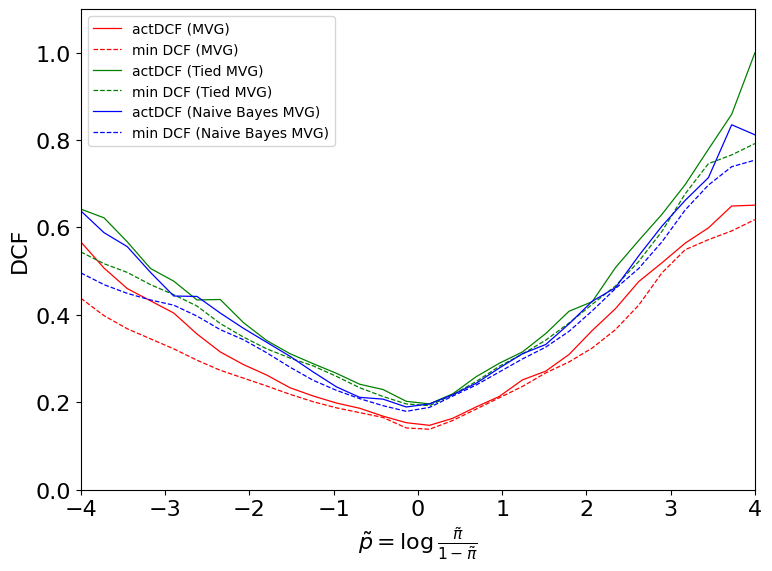

In [12]:
our_models = DCFs[(0.1, 1.0, 1.0)]
best_PCA_model = [item for item in our_models if item['PCA Directions']==1][0]

mvg = best_PCA_model['MVG']

effPriorLogOdds = numpy.linspace(-4, 4, 30)
actDCFs = {m: [] for m, _ in models.items()}
minDCFs = {m: [] for m, _ in models.items()}

for logOdd in effPriorLogOdds:
  prior = 1/(1 + numpy.exp(-logOdd))
  for model, func in models.items():
    DCFu, actDCF, minDCF = train_model_DCF(DTR_selected, LTR, DVAL_selected, prior, ML_func = func)
    actDCFs[model].append(round(actDCF, 3))
    minDCFs[model].append(round(minDCF, 3))

colors = {'MVG': 'r', 'Tied MVG': 'g', 'Naive Bayes MVG': 'b'}
plt.figure(figsize=(8,6), tight_layout=True)
for m, _ in models.items():
  plt.plot(effPriorLogOdds, actDCFs[m], label=f'actDCF ({m})', color=colors[m], linestyle='-', linewidth='0.9')
  plt.plot(effPriorLogOdds, minDCFs[m], label=f'min DCF ({m})', color=colors[m], linestyle='--', linewidth='0.9')

plt.ylim([0, 1.1])
plt.xlim([-4, 4])
plt.legend(fontsize=10)
plt.xlabel(r"$\tilde{p} = \log\frac{\tilde{\pi}}{1 - \tilde{\pi}}$")
plt.ylabel("DCF")

plt.savefig('./outputs/L7/Bayes_error_plot.pdf')
plt.savefig('./outputs/L7/Bayes_error_plot.jpg')
plt.show()